In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score


In [ ]:
file_path = '/content/drive/My Drive/IDC/Year 3/Final Project/fetal_health.csv'
data = pd.read_csv(file_path)
results_path = '/content/drive/My Drive/IDC/Year 3/Final Project/models_results.csv'

In [ ]:

# Splitting the data into features and target variable
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

# Stratified split of the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Binarizing the test and validation labels
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_val_binarized = label_binarize(y_val, classes=[1, 2, 3])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Checking the splits
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 1488
Validation set size: 319
Test set size: 319


In [ ]:
class_mapping = { 1: "normal", 2: "suspect", 3: "pathological" }

In [ ]:
def evaluate_model_and_update_csv(y_true, y_pred, y_pred_proba, y_true_binarized, model_name):
    # Confusion Matrix and Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
    plt.title(f'{model_name} Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Model Accuracy and Per-Class Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"Accuracy of {model_name} on Test: {accuracy * 100:.2f}%\n")
    for i, acc in enumerate(per_class_accuracy):
        class_name = class_mapping[i + 1]  # Assuming class_mapping starts at 1
        print(f"Accuracy for {class_name} on Test: {acc * 100:.2f}%")

    # AUC Calculation
    n_classes = len(np.unique(y_true))  # Assuming y_true contains all classes
    roc_auc_dict = {}
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i + 1] = auc(fpr, tpr)

    # Print AUC scores
    print(f"\nAUC Scores on Test:")
    for class_id in class_mapping:
        if class_id in roc_auc_dict:
            print(f"AUC for class '{class_mapping[class_id]}' on Test: {roc_auc_dict[class_id]:.2f}")

    # Store results in a dictionary
    results = {
        'Model Name': model_name,
        'Overall Acc': round(accuracy * 100, 2),
        'Class Normal Acc': round(per_class_accuracy[0] * 100, 2),
        'Class Suspect Acc': round(per_class_accuracy[1] * 100, 2),
        'Class Patho Acc': round(per_class_accuracy[2] * 100, 2),
        'Class Normal AUC': round(roc_auc_dict[1], 2),
        'Class Suspect AUC': round(roc_auc_dict[2], 2),
        'Class Patho AUC': round(roc_auc_dict[3], 2)
    }

    df_existing = pd.read_csv(results_path)
    df_updated = pd.concat([df_existing, pd.DataFrame([results])], ignore_index=True)
    #df_updated.to_csv(results_path, index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

def evaluate_model_with_visualization(y_pred, y_pred_proba, model_name, y_test, class_mapping, y_test_binarized):
    # Confusion Matrix and Calculation
    cm = confusion_matrix(y_test, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    overall_accuracy = accuracy_score(y_test, y_pred)

    # AUC Calculation
    n_classes = len(np.unique(y_test))
    roc_auc_dict = {}
    fpr_dict, tpr_dict = {}, {}
    for i in range(n_classes):
        fpr_dict[i + 1], tpr_dict[i + 1], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i + 1] = auc(fpr_dict[i + 1], tpr_dict[i + 1])

    # Plot 1: Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g',
                xticklabels=["normal", "suspect", "pathological"],
                yticklabels=["normal", "suspect", "pathological"])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot 2: ROC/AUC Curve
    plt.figure(figsize=(6, 6))
    for i in range(n_classes):
        plt.plot(fpr_dict[i + 1], tpr_dict[i + 1], label=f'{class_mapping[i + 1]} (AUC = {roc_auc_dict[i + 1]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC/AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot 3: Accuracy Table with Overall Accuracy
    plt.figure(figsize=(4, 2))
    plt.axis('off')
    accuracy_data = {
        'Class': [class_mapping[1], class_mapping[2], class_mapping[3], 'Overall'],
        'Accuracy': [f"{per_class_accuracy[0] * 100:.2f}%",
                     f"{per_class_accuracy[1] * 100:.2f}%",
                     f"{per_class_accuracy[2] * 100:.2f}%",
                     f"{overall_accuracy * 100:.2f}%"]
    }
    accuracy_df = pd.DataFrame(accuracy_data)
    tbl = plt.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.5)
    plt.title(f'{model_name} Accuracy Table')
    plt.show()

# Example usage:
# evaluate_model_with_visualization(y_pred, y_pred_proba, "Plain LR", y_test, class_mapping, y_test_binarized)


# Weighted Penalty

In [ ]:
def generate_class_weights(start, end, step):
    weights = np.arange(start, end + step, step)
    class_weights = []
    for w1 in weights:
        for w2 in weights:
            for w3 in weights:
                class_weights.append({1: w1, 2: w2, 3: w3})
    return class_weights

# Generate class weights starting from 0 to 10 in 0.5 intervals
class_weights = generate_class_weights(0, 5, 0.5)

In [ ]:
# LR Grid Search

'''
best_score = 0
best_class_weight = None

# Loop over the class weights to find the best one on the training set
for class_weight in class_weights:
    lr_model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    lr_model.fit(X_train_scaled, y_train)
    y_val_pred = lr_model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_val_pred)

    # Update the best score, class weight if the current score is better
    if accuracy > best_score:
        best_score = accuracy
        best_class_weight = class_weight
'''

'\nbest_score = 0\nbest_class_weight = None\n\n# Loop over the class weights to find the best one on the training set\nfor class_weight in class_weights:\n    lr_model = LogisticRegression(max_iter=1000, class_weight=class_weight)\n    lr_model.fit(X_train_scaled, y_train)\n    y_val_pred = lr_model.predict(X_val_scaled)\n    accuracy = accuracy_score(y_val, y_val_pred)\n\n    # Update the best score, class weight if the current score is better\n    if accuracy > best_score:\n        best_score = accuracy\n        best_class_weight = class_weight\n'

Using best parameters found: {1: 3.5, 2: 1.0, 3: 1.5}


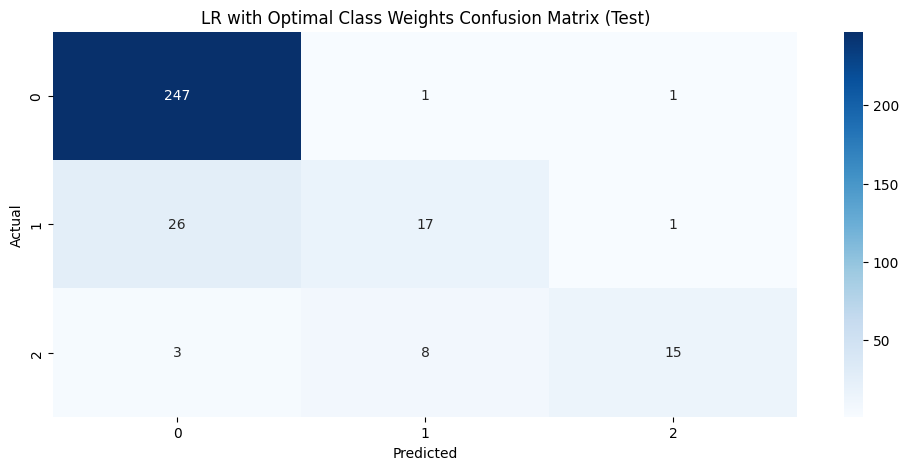

Accuracy of LR with Optimal Class Weights on Test: 87.46%

Accuracy for normal on Test: 99.20%
Accuracy for suspect on Test: 38.64%
Accuracy for pathological on Test: 57.69%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.97
AUC for class 'suspect' on Test: 0.92
AUC for class 'pathological' on Test: 0.98


In [ ]:
best_class_weight = {1: 3.5, 2: 1.0, 3: 1.5}
# LR with suggested weights
print(f"Using best parameters found: {best_class_weight}")

# Train a final model with the best class weight
final_lr_model = LogisticRegression(
    max_iter=1000,
    class_weight=best_class_weight
)
final_lr_model.fit(X_train_scaled, y_train)
y_test_lr_pred = final_lr_model.predict(X_test_scaled)
y_test_lr_pred_proba = final_lr_model.predict_proba(X_test_scaled)

evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_lr_pred,
    y_pred_proba=y_test_lr_pred_proba,
    y_true_binarized=y_test_binarized,
    model_name='LR with Optimal Class Weights'
)

* The overall accuracy is 90.14%, with high accuracy for the "normal" class at 92.47%
* achieves respectable accuracies for the "suspect" and "pathological" classes at 83.05% and 80.00%

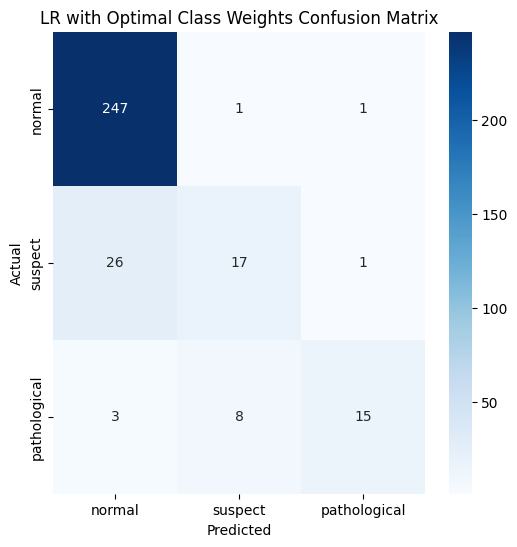

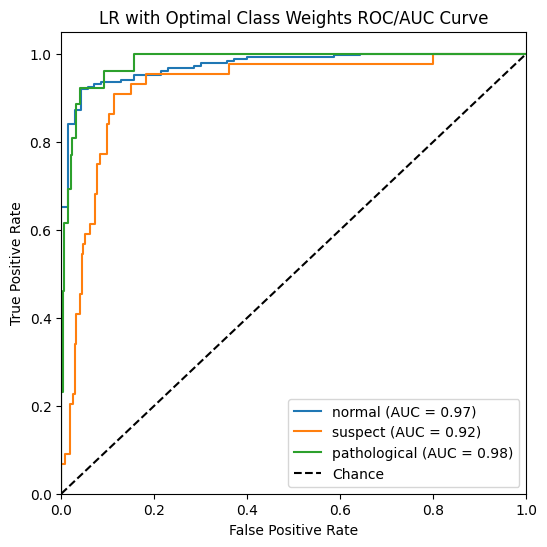

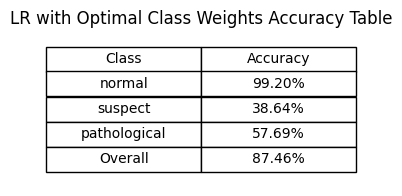

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_lr_pred,
    y_pred_proba=y_test_lr_pred_proba,
    model_name='LR with Optimal Class Weights',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


In [ ]:
# DT Grid Search

'''
best_score = 0
best_class_weight = None
random_state_fixed = 42  # Setting a fixed random state for reproducibility

# Loop over the class weights to find the best one on the training set
for class_weight in class_weights:
    dt_model = DecisionTreeClassifier(class_weight=class_weight, random_state=random_state_fixed)
    dt_model.fit(X_train_scaled, y_train)
    y_pred = dt_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # Update the best score and class weight if the current score is better
    if accuracy > best_score:
        best_score = accuracy
        best_class_weight = class_weight
'''

'\nbest_score = 0\nbest_class_weight = None\nrandom_state_fixed = 42  # Setting a fixed random state for reproducibility\n\n# Loop over the class weights to find the best one on the training set\nfor class_weight in class_weights:\n    dt_model = DecisionTreeClassifier(class_weight=class_weight, random_state=random_state_fixed)\n    dt_model.fit(X_train_scaled, y_train)\n    y_pred = dt_model.predict(X_test_scaled)\n    accuracy = accuracy_score(y_test, y_pred)\n\n    # Update the best score and class weight if the current score is better\n    if accuracy > best_score:\n        best_score = accuracy\n        best_class_weight = class_weight\n'

Using best parameters found for Decision Tree: {1: 1.0, 2: 4.5, 3: 4.0}


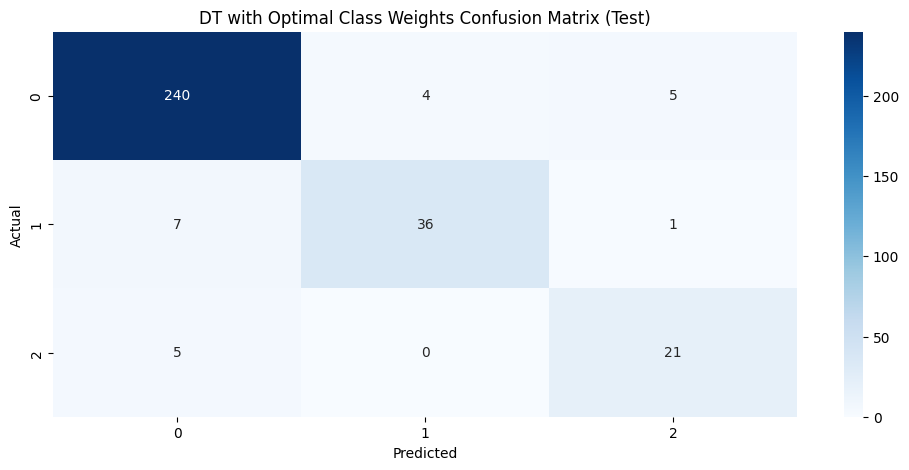

Accuracy of DT with Optimal Class Weights on Test: 93.10%

Accuracy for normal on Test: 96.39%
Accuracy for suspect on Test: 81.82%
Accuracy for pathological on Test: 80.77%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.90
AUC for class 'suspect' on Test: 0.90
AUC for class 'pathological' on Test: 0.89


In [ ]:
best_class_weight = {1: 1.0, 2: 4.5, 3: 4.0}
random_state_fixed = 42

# DT:  WITH SUGGESTED WEIGHTS
print(f"Using best parameters found for Decision Tree: {best_class_weight}")
final_dt_model = DecisionTreeClassifier(
    class_weight=best_class_weight,
    random_state=random_state_fixed
)
final_dt_model.fit(X_train_scaled, y_train)
y_test_dt_pred = final_dt_model.predict(X_test_scaled)
y_test_dt_pred_proba = final_dt_model.predict_proba(X_test_scaled)

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_dt_pred,
    y_pred_proba=y_test_dt_pred_proba,
    y_true_binarized=y_test_binarized,
    model_name='DT with Optimal Class Weights'
)

* The model performs exceptionally well in classifying the "normal" fetal health category, achieving an accuracy of 97.29%

* The accuracy for the "suspect" class is notably lower at 71.19%

* Despite variations in accuracy across classes, the AUC values remain relatively consistent, with values ranging from 0.80 to 0.91. This suggests that the model maintains a consistent ability to rank instances across different classes based on their predicted probabilities

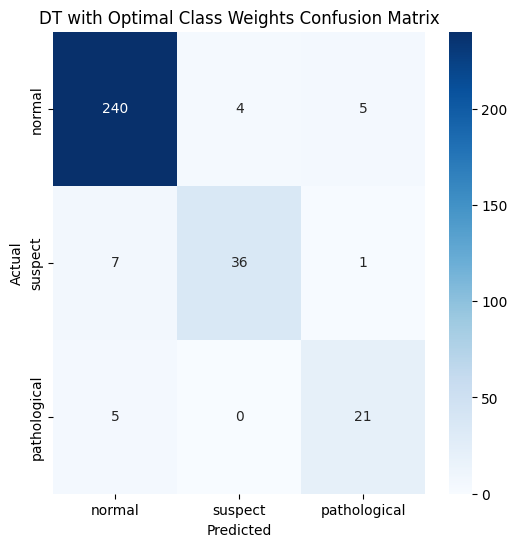

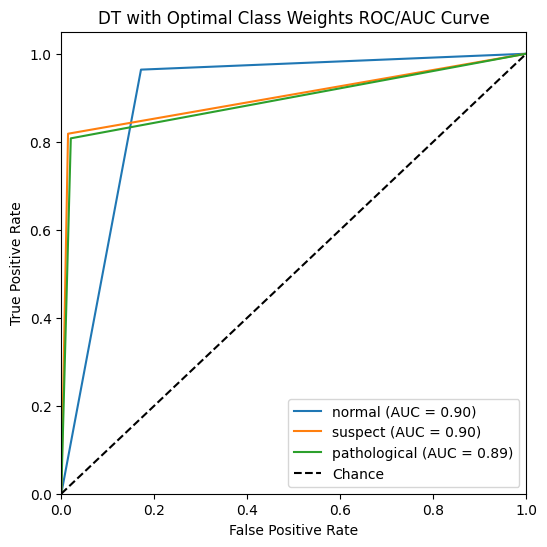

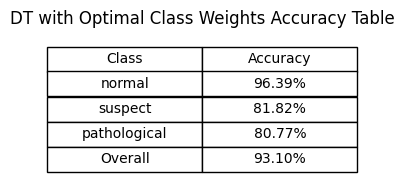

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_dt_pred,
    y_pred_proba=y_test_dt_pred_proba,
    model_name='DT with Optimal Class Weights',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


# 1 vs all Anomaly Detection Approach (SVM)

* Handling multi class classification tasks by training multiple binary classifiers (one for each class)
* Each SVM is trained to distinguish between one vs all other classes
* During training, one class is labeled as + and all others -
* During prediction, each classifer outputs a decision score for each sample. The class with the highest score is assigned to the sample

In [ ]:
# train SVM models for one-vs-all classification
def train_one_vs_all_models(X_train, y_train, classes):
    models = []
    for class_label in classes:

        # Create a binary target variable for each class
        y_train_binary = (y_train == class_label).astype(int)

        # Train an SVM model on this binary target
        model = SVC(probability=True, random_state=42)
        model.fit(X_train, y_train_binary)
        models.append(model)

    return models

# function for combined prediction using all SVM models
def combined_prediction(models, X):
    probabilities = [model.predict_proba(X)[:, 1] for model in models]
    predicted_classes = np.argmax(probabilities, axis=0) + 1  # Adding 1 to match class labels
    return predicted_classes, probabilities

# Train the one-vs-all models using the training set
classes = np.unique(y_train)
svm_models = train_one_vs_all_models(X_train_scaled, y_train, classes)

# Predict using the combined model on the validation set
y_val_pred_svm, _ = combined_prediction(svm_models, X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_svm)

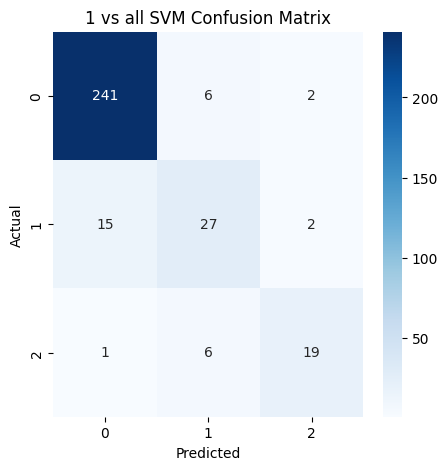


Accuracy of the model: 89.97%

Accuracy for class '1.0': 96.79%
Accuracy for class '2.0': 61.36%
Accuracy for class '3.0': 73.08%

AUC for each class:
AUC for class '1.0': 0.97
AUC for class '2.0': 0.93
AUC for class '3.0': 0.97


In [ ]:
y_test_pred_svm, y_test_pred_proba_svm = combined_prediction(svm_models, X_test_scaled)

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt='g')
plt.title('1 vs all SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy and per-class accuracy
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
per_class_accuracy_svm = cm_svm.diagonal() / cm_svm.sum(axis=1)
print("\nAccuracy of the model: {:.2f}%\n".format(accuracy_svm * 100))
for class_label, acc in zip(classes, per_class_accuracy_svm):
    print(f"Accuracy for class '{class_label}': {acc * 100:.2f}%")

# AUC calculation
roc_auc_dict_svm = {}
for class_label, model in zip(classes, svm_models):
    class_binary = (y_test == class_label).astype(int)
    y_pred_proba_class = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(class_binary, y_pred_proba_class)
    roc_auc = auc(fpr, tpr)
    roc_auc_dict_svm[class_label] = roc_auc

print("\nAUC for each class:")
for class_label in classes:
    print(f"AUC for class '{class_label}': {roc_auc_dict_svm[class_label]:.2f}")

# Store results in a dictionary
results = {
    'Model Name': "1 vs all SVM",
    'Overall Acc': round(accuracy_svm * 100, 2),
    'Class Normal Acc': round(per_class_accuracy_svm[0] * 100, 2),
    'Class Suspect Acc': round(per_class_accuracy_svm[1] * 100, 2),
    'Class Patho Acc': round(per_class_accuracy_svm[2] * 100, 2),
    'Class Normal AUC': round(roc_auc_dict_svm[1], 2),
    'Class Suspect AUC': round(roc_auc_dict_svm[2], 2),
    'Class Patho AUC': round(roc_auc_dict_svm[3], 2)
}

df_existing = pd.read_csv(results_path)
df_updated = pd.concat([df_existing, pd.DataFrame([results])], ignore_index=True)
df_updated.to_csv(results_path, index=False)

* overall accuracy is 89.91%
* normal class achieved the highest accuracy of 96.69%
* suspect class has a significantly lower accuracy of 59.32%, indicating that the model struggles more with correctly classifying instances belonging to this class. Despite this, the AUC for suspect class is still relatively high at 0.93
* patholigcal class achieves an accuracy of 77.14%, showing moderate performance compared to the other classes, with an AUC of 0.98

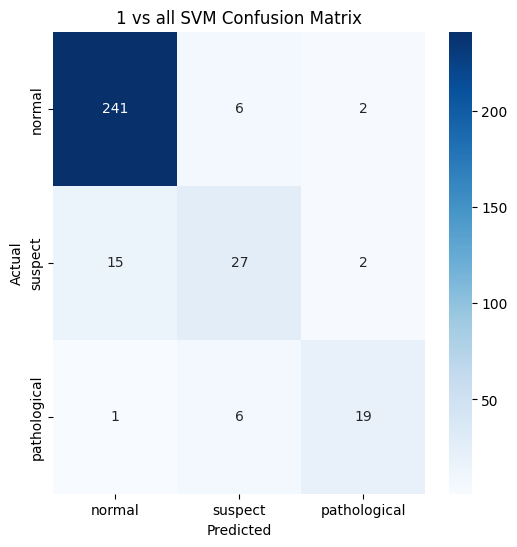

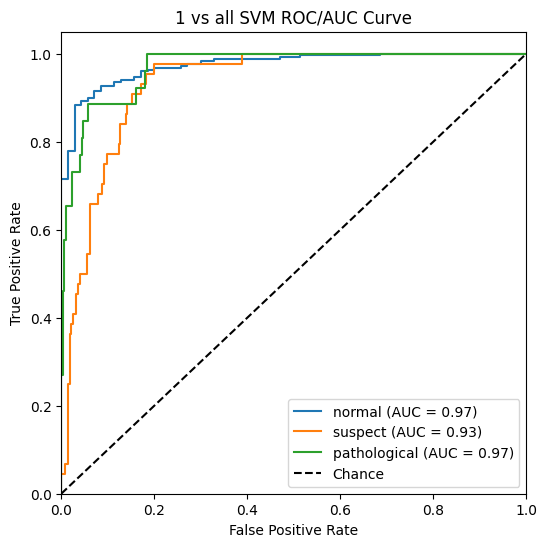

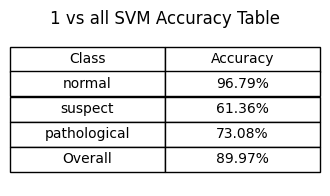

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

# Confusion Matrix and Calculation
cm = confusion_matrix(y_test, y_test_pred_svm)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
overall_accuracy = accuracy_score(y_test, y_test_pred_svm)

# AUC Calculation
roc_auc_dict = {}
fpr_dict, tpr_dict = {}, {}
for idx, class_label in enumerate(classes):
    y_test_binary = (y_test == class_label).astype(int)
    fpr_dict[class_label], tpr_dict[class_label], _ = roc_curve(y_test_binary, y_test_pred_proba_svm[idx])
    roc_auc_dict[class_label] = auc(fpr_dict[class_label], tpr_dict[class_label])

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g',
            xticklabels=[class_mapping[cls] for cls in classes],
            yticklabels=[class_mapping[cls] for cls in classes])
plt.title('1 vs all SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot 2: ROC/AUC Curve
plt.figure(figsize=(6, 6))
for class_label in classes:
    plt.plot(fpr_dict[class_label], tpr_dict[class_label],
             label=f'{class_mapping[class_label]} (AUC = {roc_auc_dict[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('1 vs all SVM ROC/AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot 3: Accuracy Table with Overall Accuracy
plt.figure(figsize=(4, 2))
plt.axis('off')
accuracy_data = {
    'Class': [class_mapping[cls] for cls in classes] + ['Overall'],
    'Accuracy': [f"{acc * 100:.2f}%" for acc in per_class_accuracy] + [f"{overall_accuracy * 100:.2f}%"]
}
accuracy_df = pd.DataFrame(accuracy_data)
tbl = plt.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)
plt.title('1 vs all SVM Accuracy Table')
plt.show()


# Decision Trees: Bagging Techniques
Take into account the direction of the mistake

* Ensemble method that uses multiple instances of decision tree to create a set of classifiers by training each on random subsets of the original dataset
* Each base DT is trained on a different sample of the data in parallel with other base DTs
* Predictions are aggregated: reduced variance


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Validation Accuracy: 92.16%


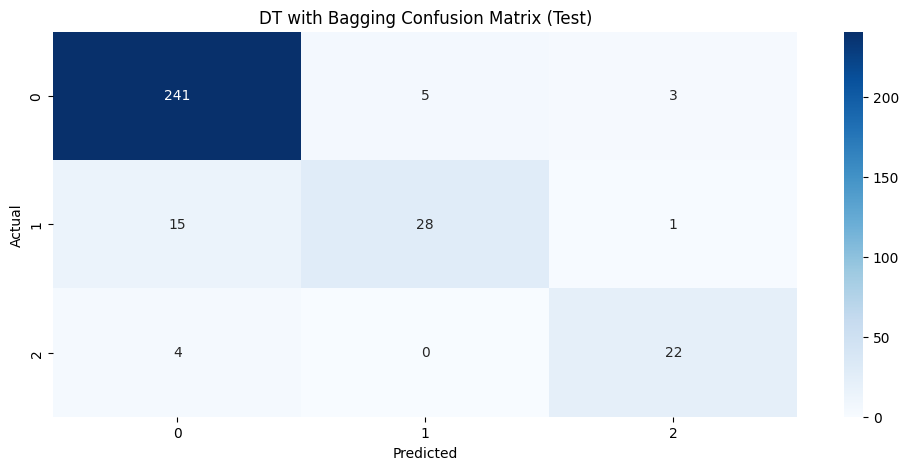

Accuracy of DT with Bagging on Test: 91.22%

Accuracy for normal on Test: 96.79%
Accuracy for suspect on Test: 63.64%
Accuracy for pathological on Test: 84.62%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.97
AUC for class 'suspect' on Test: 0.97
AUC for class 'pathological' on Test: 0.95


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)

bagging_clf.fit(X_train_scaled, y_train)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_bagging = bagging_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_bagging)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_bagging = bagging_clf.predict(X_test_scaled)
y_test_pred_proba_bagging = bagging_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_pred_bagging,
    y_pred_proba=y_test_pred_proba_bagging,
    y_true_binarized=y_test_binarized,
    model_name='DT with Bagging'
)

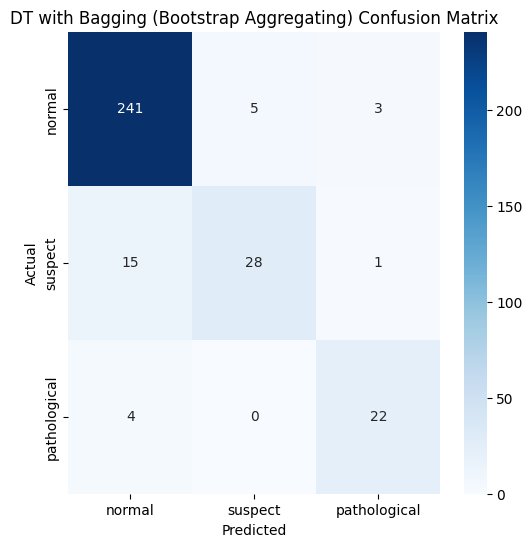

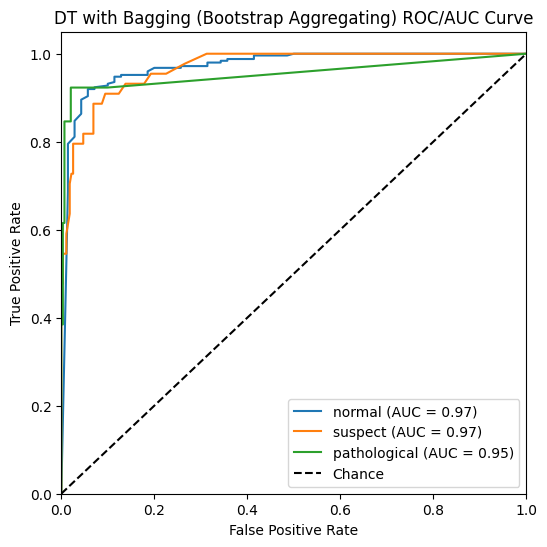

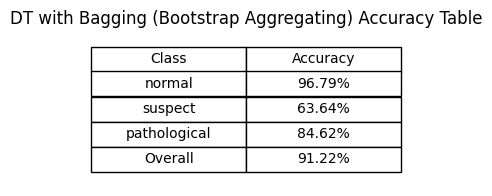

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_pred_bagging,
    y_pred_proba=y_test_pred_proba_bagging,
    model_name='DT with Bagging (Bootstrap Aggregating)',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


Random Forest

* Constructs multitde of DTs at training time, outputs the class that is the mode of the classes predicted by each individual tree

Validation Accuracy: 93.10%


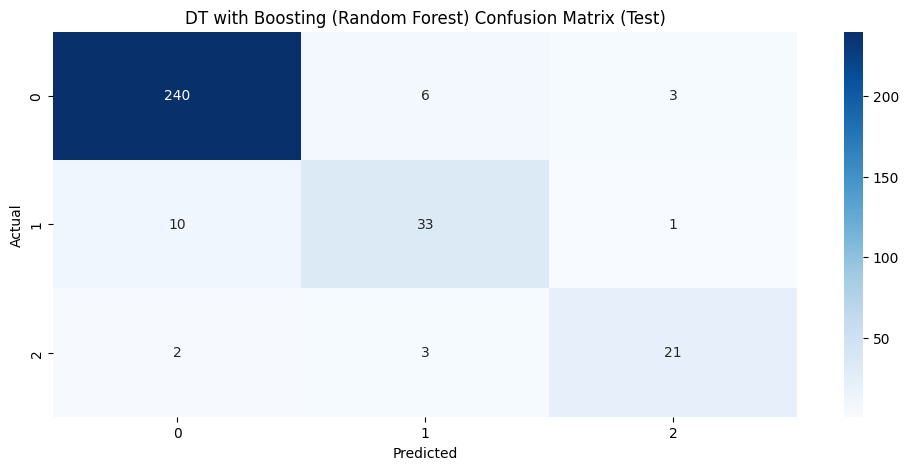

Accuracy of DT with Boosting (Random Forest) on Test: 92.16%

Accuracy for normal on Test: 96.39%
Accuracy for suspect on Test: 75.00%
Accuracy for pathological on Test: 80.77%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.98
AUC for class 'suspect' on Test: 0.96
AUC for class 'pathological' on Test: 0.99


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define and train the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_clf.fit(X_train_scaled, y_train)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_rf = rf_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_rf = rf_clf.predict(X_test_scaled)
y_test_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_pred_rf,
    y_pred_proba=y_test_pred_proba_rf,
    y_true_binarized=y_test_binarized,
    model_name='DT with Boosting (Random Forest)'
)

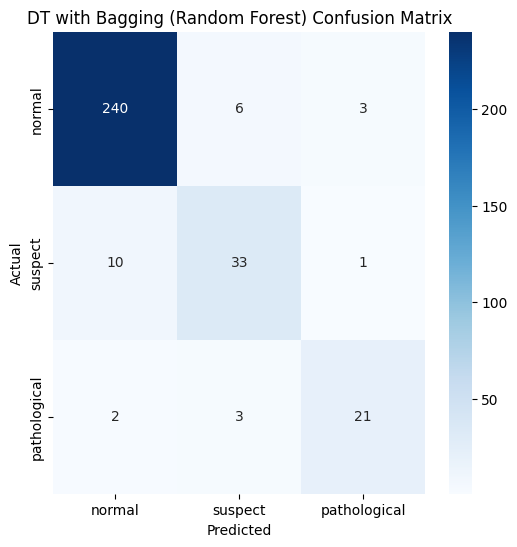

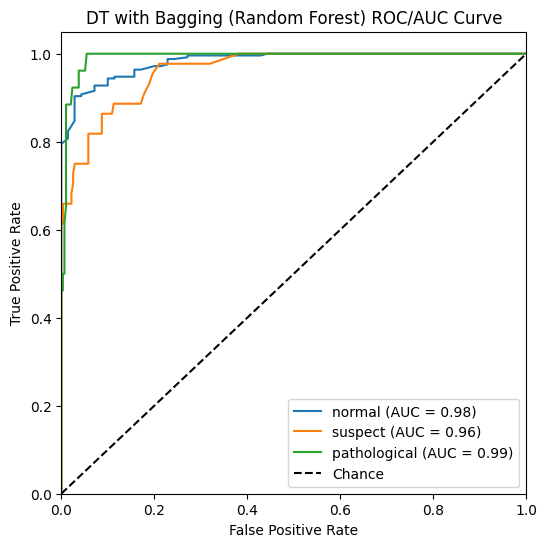

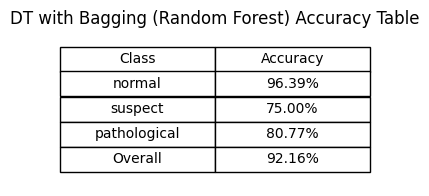

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_pred_rf,
    y_pred_proba=y_test_pred_proba_rf,
    model_name='DT with Bagging (Random Forest)',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


# Decision Trees: Boosting Techniques

Gradiated Trees
* Trains DTs one at a time, so each tree helps to correct errors made by previously trained trees
* Lower learning rate requires more trees to model all the relationships and can reduce overfitting

Validation Accuracy: 92.48%


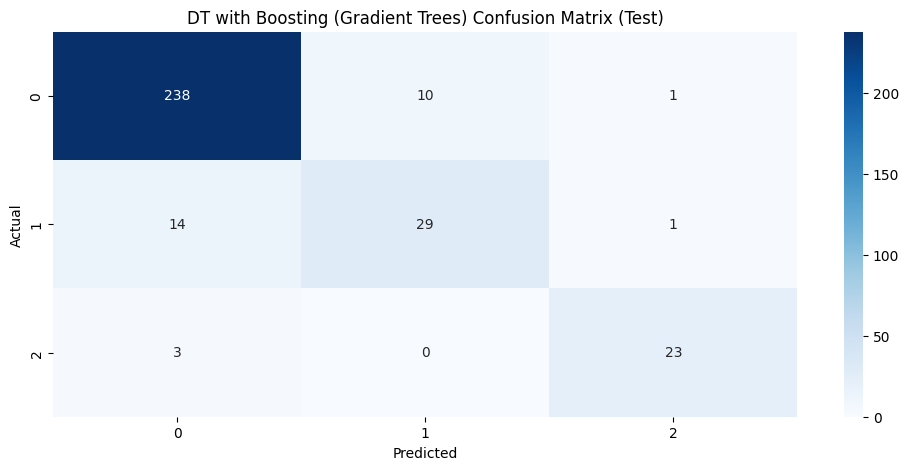

Accuracy of DT with Boosting (Gradient Trees) on Test: 90.91%

Accuracy for normal on Test: 95.58%
Accuracy for suspect on Test: 65.91%
Accuracy for pathological on Test: 88.46%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.85
AUC for class 'suspect' on Test: 0.81
AUC for class 'pathological' on Test: 0.93


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define and train the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

# Train the model on the training set
gb_clf.fit(X_train_scaled, y_train)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_gb = gb_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_gb)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_gb = gb_clf.predict(X_test_scaled)
y_test_pred_proba_gb = gb_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_pred_gb,
    y_pred_proba=y_test_pred_proba_gb,
    y_true_binarized=y_test_binarized,
    model_name='DT with Boosting (Gradient Trees)'
)

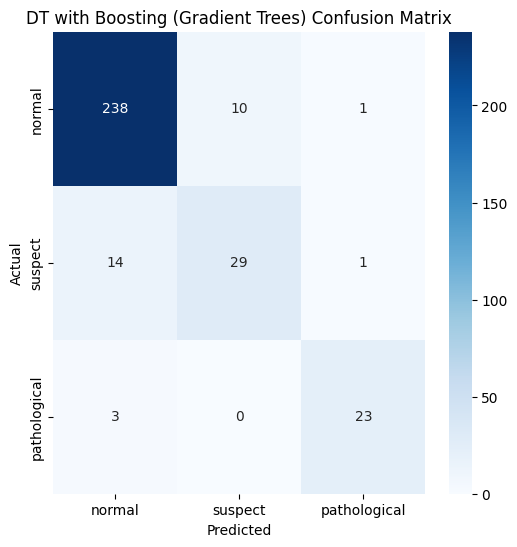

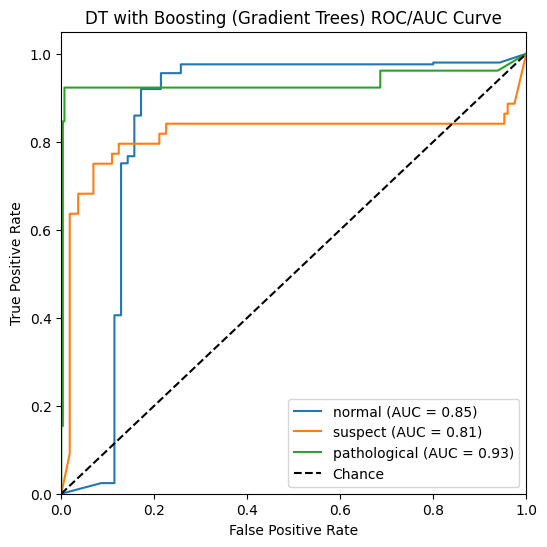

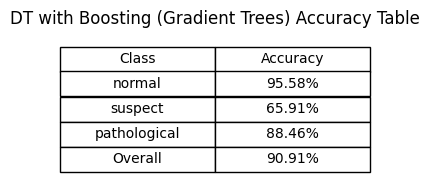

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_pred_gb,
    y_pred_proba=y_test_pred_proba_gb,
    model_name='DT with Boosting (Gradient Trees)',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


# CatBoost
* Gradient boosting on DTs, specifically for categorical data
* Converts categorical variables into numerical format
* Grows symmetric trees, so all leaf nodes at the same level share the same decision rule -> reduces models complexity and trianing time
* Uses an ordered boosting scheme, where each tree is trained on a different random permutation of the data (uses predictions that are only based on the tree trained before it)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.4 MB/s eta 0:00:00


0:	learn: 0.9769492	total: 47.8ms	remaining: 47.7s
100:	learn: 0.1569778	total: 162ms	remaining: 1.44s
200:	learn: 0.1168522	total: 285ms	remaining: 1.13s
300:	learn: 0.0940254	total: 395ms	remaining: 918ms
400:	learn: 0.0784113	total: 512ms	remaining: 765ms
500:	learn: 0.0683061	total: 645ms	remaining: 643ms
600:	learn: 0.0596690	total: 856ms	remaining: 568ms
700:	learn: 0.0524188	total: 1.11s	remaining: 475ms
800:	learn: 0.0465827	total: 1.24s	remaining: 307ms
900:	learn: 0.0414226	total: 1.36s	remaining: 149ms
999:	learn: 0.0375550	total: 1.49s	remaining: 0us
Validation Accuracy: 93.42%


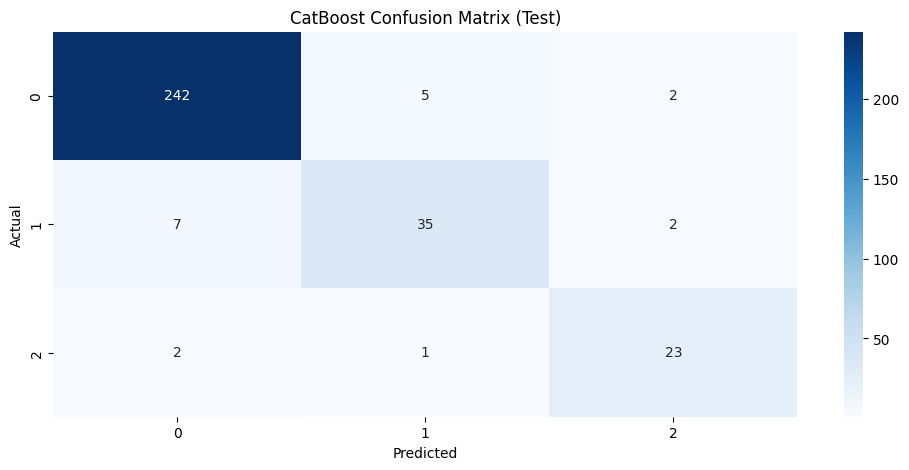

Accuracy of CatBoost on Test: 94.04%

Accuracy for normal on Test: 97.19%
Accuracy for suspect on Test: 79.55%
Accuracy for pathological on Test: 88.46%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.98
AUC for class 'suspect' on Test: 0.97
AUC for class 'pathological' on Test: 0.99


In [ ]:
from catboost import CatBoostClassifier

# Define and train the CatBoost Classifier
catboost_clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='MultiClass',
    verbose=100,
    random_seed=42
)

# Train the model on the training set
catboost_clf.fit(X_train_scaled, y_train)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_cb = catboost_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_cb)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_cb = catboost_clf.predict(X_test_scaled)
y_test_pred_proba_cb = catboost_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_pred_cb,
    y_pred_proba=y_test_pred_proba_cb,
    y_true_binarized=y_test_binarized,
    model_name='CatBoost'
)

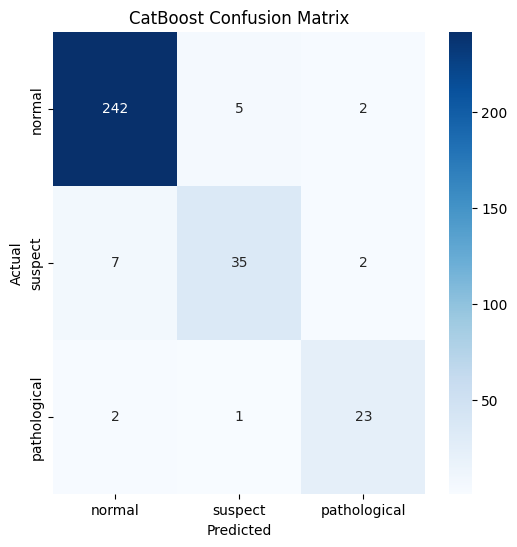

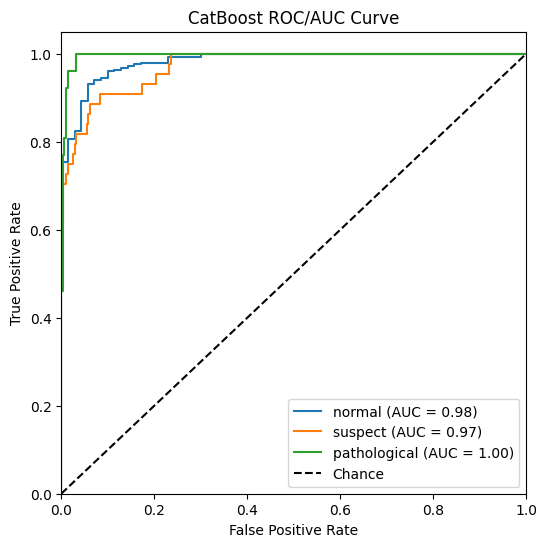

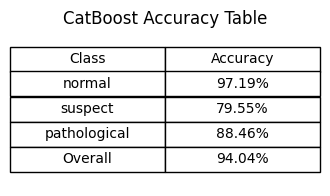

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_test_pred_cb,
    y_pred_proba=y_test_pred_proba_cb,
    model_name='CatBoost',
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


In [ ]:
'''
param_grid = {
    'learning_rate': [0.05, 0.1],
    'depth': [8, 10, 12],
    'l2_leaf_reg': [1, 3, 5],
}

# Initialize CatBoost with consistent random_seed
catboost_clf = CatBoostClassifier(
    iterations=500,
    loss_function='MultiClass',
    verbose=0,  # Keep silent to avoid iteration output
    random_seed=42
)

# Perform Grid Search with Cross-Validation
cb_grid_search = GridSearchCV(catboost_clf, param_grid, cv=3, scoring='accuracy', verbose=0)
cb_grid_search.fit(X_train_scaled, y_train)

# Extract the best parameters
cb_best_params = cb_grid_search.best_params_
print(f"Best parameters: {cb_best_params}")
'''
cb_best_params = {'depth': 8, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [ ]:
'''
# Plotting parameters
cv_results = pd.DataFrame(cb_grid_search.cv_results_)
results_summary = cv_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample', 'param_colsample_bytree', 'mean_test_score']]
results_summary.columns = ['Max Depth', 'Learning Rate', 'N Estimators', 'Subsample', 'Colsample Bytree', 'Mean Accuracy']

# Convert to percentage and sort
results_summary['Mean Accuracy'] = results_summary['Mean Accuracy'] * 100
results_summary = results_summary.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)

# Select only the top 10 highest accuracies
top_10_results_summary = results_summary.head(10)

# Plotting the table for top 10 results
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=top_10_results_summary.values, colLabels=top_10_results_summary.columns, cellLoc='center', loc='center')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.title('Top 10 Grid Search Results Summary')
plt.show()
'''

"\n# Plotting parameters\ncv_results = pd.DataFrame(cb_grid_search.cv_results_)\nresults_summary = cv_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample', 'param_colsample_bytree', 'mean_test_score']]\nresults_summary.columns = ['Max Depth', 'Learning Rate', 'N Estimators', 'Subsample', 'Colsample Bytree', 'Mean Accuracy']\n\n# Convert to percentage and sort\nresults_summary['Mean Accuracy'] = results_summary['Mean Accuracy'] * 100\nresults_summary = results_summary.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)\n\n# Select only the top 10 highest accuracies\ntop_10_results_summary = results_summary.head(10)\n\n# Plotting the table for top 10 results\nfig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed\nax.axis('tight')\nax.axis('off')\nthe_table = ax.table(cellText=top_10_results_summary.values, colLabels=top_10_results_summary.columns, cellLoc='center', loc='center')\n\n# Adjust layout to make roo

Validation Accuracy: 93.73%


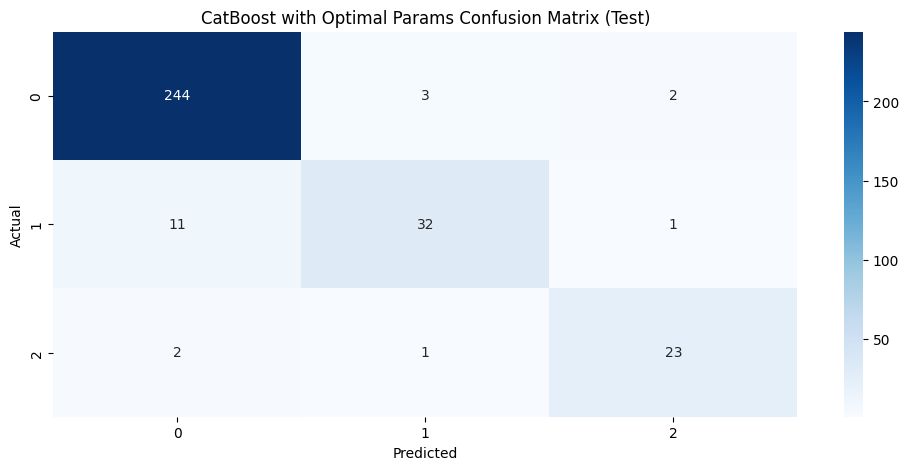

Accuracy of CatBoost with Optimal Params on Test: 93.73%

Accuracy for normal on Test: 97.99%
Accuracy for suspect on Test: 72.73%
Accuracy for pathological on Test: 88.46%

AUC Scores on Test:
AUC for class 'normal' on Test: 0.98
AUC for class 'suspect' on Test: 0.97
AUC for class 'pathological' on Test: 1.00


In [ ]:
# Train a new model with the best parameters found
best_catboost_clf = CatBoostClassifier(
    iterations=500,
    loss_function='MultiClass',
    verbose=0,  # Keep silent to avoid iteration output
    random_seed=42,
    depth=cb_best_params['depth'],
    l2_leaf_reg=cb_best_params['l2_leaf_reg'],
    learning_rate=cb_best_params['learning_rate']
)
best_catboost_clf.fit(X_train_scaled, y_train)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_cb = best_catboost_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred_cb)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_best = best_catboost_clf.predict(X_test_scaled)
y_test_pred_proba_cb = best_catboost_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test,
    y_pred=y_test_pred_best,
    y_pred_proba=y_test_pred_proba_cb,
    y_true_binarized=y_test_binarized,
    model_name='CatBoost with Optimal Params'
)

* In cross-validation, the training data is split into multiple smaller sets (folds)
  *  For each fold, model is trained on the remaining data and then tested on that fold. This process is repeated until each fold serves as the test set once

* Performance metrics from each fold are averaged to produce a single value (mean accuracy): represents the model's overall performance across all the folds

* This mean accuracy is an estimation based on the training data.
* Performance can vary from one fold to another during cross-validation

* Mean accuracy from cross-validation might not be identical to the accuracy obtained on a separate single test set

Test Set Accuracy gives you an estimate of how well the model is expected to perform on new, unseen data

Mean Cross-Validation Accuracy is the average accuracy score from cross-validation, where the training set is split into k smaller sets (folds). The model is trained on k-1 of these folds and validated on the remaining part. This process is repeated k times (folds), with each of the k subsets used exactly once as the validation data. The mean cross-validation accuracy is the average of the k accuracy scores obtained from the k iterations.

Cross-validation accuracy gives more robust estimate of the model's performance because it reduces the variance associated with a single trial of a train-test split

# XGBoost
* optimizes loss function and regularization term to prevent overfitting
* builds a tree using a level wise growth strategy so more balanced trees
* uses L1 and L2 regularization terms in objective function

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

Validation Accuracy: 94.67%


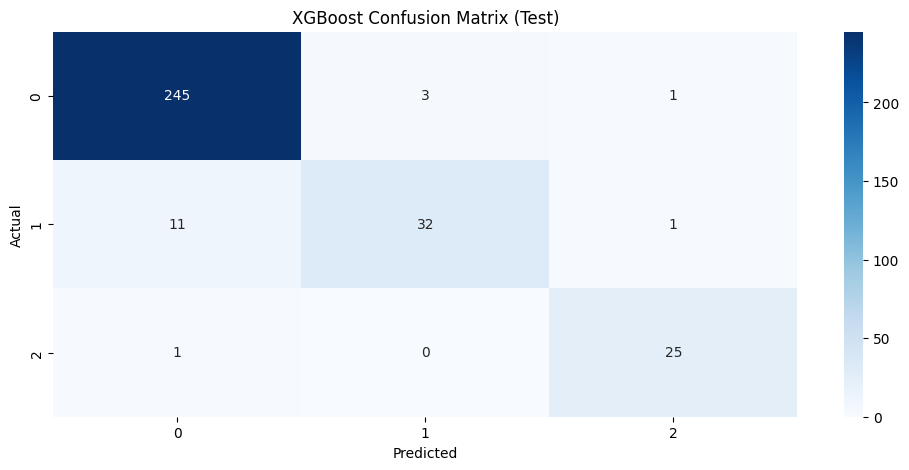

Accuracy of XGBoost on Test: 94.67%

Accuracy for 0 on Test: 98.39%
Accuracy for 1 on Test: 72.73%
Accuracy for 2 on Test: 96.15%

AUC Scores on Test:
AUC for class '0' on Test: 0.98
AUC for class '1' on Test: 0.98
AUC for class '2' on Test: 0.99


In [ ]:
import xgboost as xgb

# Define a mapping from your original class labels to the required labels
class_mapping = {1: 0, 2: 1, 3: 2}

# Map the class labels in y_train, y_val, and y_test
y_train_mapped = y_train.map(class_mapping)
y_val_mapped = y_val.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Create and fit the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_mapped)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_xg = xgb_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val_mapped, y_val_pred_xg)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_xg = xgb_clf.predict(X_test_scaled)
y_test_pred_proba_xg = xgb_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test_mapped, classes=[0, 1, 2])

# Evaluate the final model on the test set
evaluate_model_and_update_csv(
    y_true=y_test_mapped,
    y_pred=y_test_pred_xg,
    y_pred_proba=y_test_pred_proba_xg,
    y_true_binarized=y_test_binarized,
    model_name='XGBoost'
)

Validation Accuracy: 94.67%


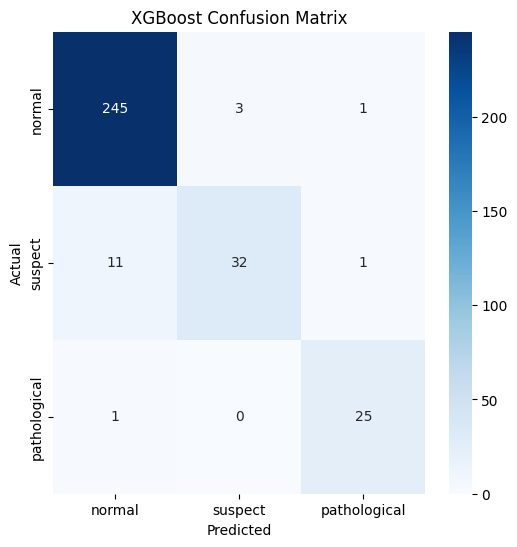

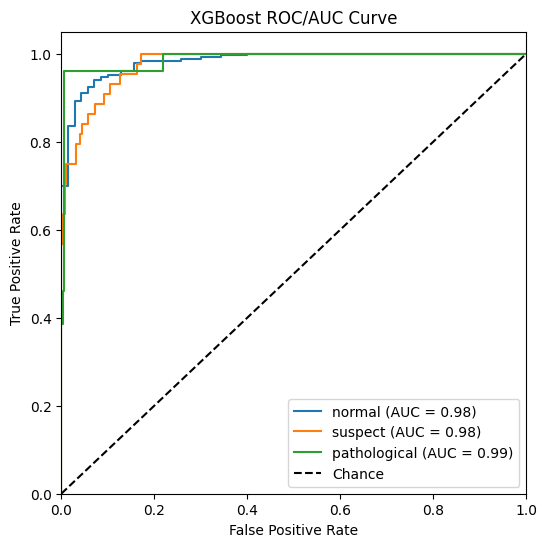

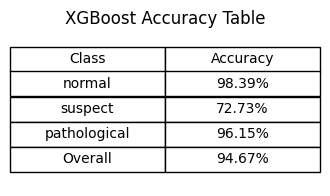

In [ ]:
import xgboost as xgb

# Define a mapping from your original class labels to the required labels
class_mapping = {1: 0, 2: 1, 3: 2}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Map the class labels in y_train, y_val, and y_test
y_train_mapped = y_train.map(class_mapping)
y_val_mapped = y_val.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Create and fit the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_mapped)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_xg = xgb_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val_mapped, y_val_pred_xg)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_xg_mapped = xgb_clf.predict(X_test_scaled)
y_test_pred_proba_xg = xgb_clf.predict_proba(X_test_scaled)

# Reverse the mapping for y_test_pred_xg to match the original class labels
y_test_pred_xg = pd.Series(y_test_pred_xg_mapped).map(reverse_class_mapping)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

evaluate_model_with_visualization(
    y_pred=y_test_pred_xg,
    y_pred_proba=y_test_pred_proba_xg,
    model_name='XGBoost',
    y_test=y_test,
    class_mapping={1: 'normal', 2: 'suspect', 3: 'pathological'},
    y_test_binarized=y_test_binarized
)


In [ ]:
'''
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Initialize XGBoost with consistent random_seed
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', random_state=42)  # Use 'multi:softprob' for multiclass

# Perform Grid Search with Cross-Validation
xgb_grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', verbose=1)
xgb_grid_search.fit(X_train_scaled, y_train_mapped)

# Extract the best parameters
best_params = xgb_grid_search.best_params_
print(f"Best parameters: {best_params}")
'''

best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
print(f"Best parameters: {best_params}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
'''
# Plotting parameters
cv_results = pd.DataFrame(xgb_grid_search.cv_results_)
results_summary = cv_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample', 'param_colsample_bytree', 'mean_test_score']]
results_summary.columns = ['Max Depth', 'Learning Rate', 'N Estimators', 'Subsample', 'Colsample Bytree', 'Mean Accuracy']

# Convert to percentage and sort
results_summary['Mean Accuracy'] = results_summary['Mean Accuracy'] * 100
results_summary = results_summary.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)

# Select only the top 10 highest accuracies
top_10_results_summary = results_summary.head(10)

# Plotting the table for top 10 results
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=top_10_results_summary.values, colLabels=top_10_results_summary.columns, cellLoc='center', loc='center')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.title('Top 10 Grid Search Results Summary')
plt.show()
'''

"\n# Plotting parameters\ncv_results = pd.DataFrame(xgb_grid_search.cv_results_)\nresults_summary = cv_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample', 'param_colsample_bytree', 'mean_test_score']]\nresults_summary.columns = ['Max Depth', 'Learning Rate', 'N Estimators', 'Subsample', 'Colsample Bytree', 'Mean Accuracy']\n\n# Convert to percentage and sort\nresults_summary['Mean Accuracy'] = results_summary['Mean Accuracy'] * 100\nresults_summary = results_summary.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)\n\n# Select only the top 10 highest accuracies\ntop_10_results_summary = results_summary.head(10)\n\n# Plotting the table for top 10 results\nfig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed\nax.axis('tight')\nax.axis('off')\nthe_table = ax.table(cellText=top_10_results_summary.values, colLabels=top_10_results_summary.columns, cellLoc='center', loc='center')\n\n# Adjust layout to make ro

In [ ]:
# Train a new XGBoost model with the best parameters found
best_xgb_clf = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)
best_xgb_clf.fit(X_train_scaled, y_train_mapped)

# Predict on the validation set to check performance and adjust if necessary
y_val_pred_xg = best_xgb_clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val_mapped, y_val_pred_xg)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# If validation accuracy is acceptable, evaluate on the test set
y_test_pred_best = best_xgb_clf.predict(X_test_scaled)
y_test_pred_proba_best = best_xgb_clf.predict_proba(X_test_scaled)

# Ensure that y_test_binarized is defined
y_test_binarized = label_binarize(y_test_mapped, classes=[0, 1, 2])

Validation Accuracy: 94.04%


In [ ]:
# Calculate overall accuracy
accuracy_overall = accuracy_score(y_test_mapped, y_test_pred_best)
print(f'Overall Accuracy: {accuracy_overall:.2f}')

# Calculate accuracy per class
cm = confusion_matrix(y_test_mapped, y_test_pred_best)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for class_label, acc in class_mapping.items():
    print(f"Accuracy for class {class_label}: {class_accuracy[acc]*100:.2f}%")

# Calculate AUC for each class
roc_auc_dict = {}
for class_label in class_mapping.keys():
    y_test_binary = (y_test_mapped == class_mapping[class_label]).astype(int)
    y_pred_proba_class = y_test_pred_proba_best[:, class_mapping[class_label]]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_class)
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[class_label] = roc_auc

# Print the AUC for each class
for class_label, auc_value in roc_auc_dict.items():
    print(f"AUC for class {class_label}: {auc_value:.2f}")

# Store results in a dictionary
results = {
    'Model Name': ["XGBoost"],
    'Overall Acc': [round(accuracy_overall * 100, 2)],
    'Class Normal Acc': [round(class_accuracy[class_mapping[1]] * 100, 2)],
    'Class Suspect Acc': [round(class_accuracy[class_mapping[2]] * 100, 2)],
    'Class Patho Acc': [round(class_accuracy[class_mapping[3]] * 100, 2)],
    'Class Normal AUC': [round(roc_auc_dict[1], 2)],
    'Class Suspect AUC': [round(roc_auc_dict[2], 2)],
    'Class Patho AUC': [round(roc_auc_dict[3], 2)]
}

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)
df_existing = pd.read_csv(results_path)
df_updated = pd.concat([df_existing, results_df], ignore_index=True)
df_updated.to_csv(results_path, index=False)

Overall Accuracy: 0.94
Accuracy for class 1: 97.99%
Accuracy for class 2: 72.73%
Accuracy for class 3: 96.15%
AUC for class 1: 0.98
AUC for class 2: 0.98
AUC for class 3: 0.99
